In [35]:
import torch
import wandb
import logging

import numpy as np
from hydra import initialize, compose
import matplotlib.pyplot as plt
from omegaconf import DictConfig, OmegaConf
from hydra.utils import get_original_cwd, to_absolute_path
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.utils import make_grid

from tennis_court_tracker.data.TennisCourtDataset import TennisCourtDataset, RandomCrop, TransformWrapper
from tennis_court_tracker.models.model import TrackNet
from tennis_court_tracker.predict_model import predict

from scipy.optimize import linear_sum_assignment

In [194]:
court_point_name = {
    0 : 'left-near-doubles-sideline',
    1 : 'left-near-singles-sideline',
    2 : 'right-near-singles-sideline',
    3 : 'right-near-doubles-sideline',
    4 : 'left-near-serviceline',
    5 : 'center-near-serviceline',
    6 : 'right-near-serviceline',
    7 : 'left-far-serviceline',
    8 : 'center-far-serviceline',
    9 : 'right-far-serviceline',
    10: 'left-far-doubles-sideline',
    11: 'left-far-singles-sideline',
    12: 'right-far-singles-sideline',
    13: 'right-far-doubles-sideline',
}
court_point_positions = {
    0 : (0.0,   0),
    1 : (13.7,  0),
    2 : (96.0,  0),
    3 : (109.7, 0),
    4 : (13.7,  54.8),
    5 : (54.8,  54.8),
    6 : (96.0,  54.8),
    7 : (13.7, 182.8),
    8 : (54.8, 182.8),
    9 : (96.0, 182.8),
    10: (0.0, 237.7),
    11: (13.7, 237.7),
    12: (96.0, 237.7),
    13: (109.7, 237.7)
}
court_line_names = {
    0 : 'left-doubles-sideline',
    1 : 'left-singles-sideline',
    2 : 'right-singles-sideline',
    3 : 'right-doubles-sideline',
    4 : 'near-baseline',
    5 : 'near-serviceline',
    6 : 'center-serviceline',
    7 : 'far-serviceline',
    8 : 'far-baseline'
}
court_lines = {
    0 : (0,  10),
    1 : (1,  11),
    2 : (2,  12),
    3 : (3,  13),
    4 : (0,  3),
    5 : (4,  6),
    6 : (5,  8),
    7 : (7,  9),
    8 : (10, 13)
}

court_points = np.array(list(court_point_positions.values()))

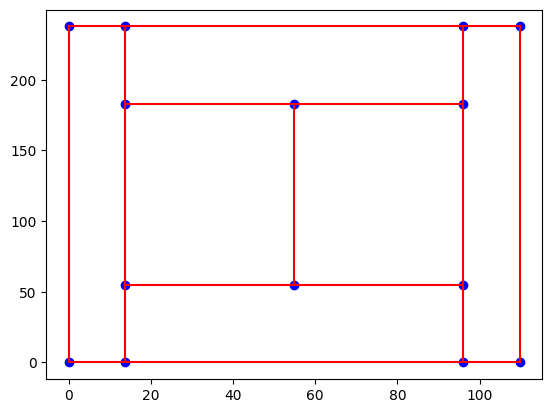

In [197]:
for (a,b) in court_lines.values():
    pa = court_point_positions[a]
    pb = court_point_positions[b]
    plt.plot([pa[0], pb[0]], [pa[1], pb[1]], '-', c='r')

for point in court_point_positions.values():
    plt.scatter(point[0], point[1], c='b')

plt.show()

In [466]:
original = np.array([
    [0,0],
    [10.97, 0],
    [0, 23.77],
    [1.37, 0],
    [1.37, 23.77],
    [9.6, 0],
    [9.6, 23.77],
    [10.97, 23.77],
    [5.485, 5.48],
    [5.485, 18.29],
    [1.37, 5.48],
    [9.6, 5.48],
    [1.37, 18.29],
    [9.6, 18.29]
], dtype=np.float32)
original *= 10

cw, ch = np.max(original[:,0]), np.max(original[:,1])

In [3]:
model_line_coords = [
    ((0, 0), (10.97, 0)),            # baseline near
    ((0, 0), (0, 23.77)),            # double sideline left
    ((1.37, 0), (1.37, 23.77)),      # single sideline left
    ((9.6, 0), (9.6, 23.77)),        # single sideline right
    ((10.97, 0), (10.97, 23.77)),    # double sidelines right
    ((5.485, 5.48), (5.485, 18.29)), # center line
    ((1.37, 5.48), (9.6, 5.48)),     # service line near
    ((1.37, 18.29), (9.6, 18.29)),   # service line far
    ((0, 23.77), (10.97, 23.77))     # baseline line far
]
labels = [
    "baseline near",
    "double sideline left",
    "single sideline left",
    "single sideline right",
    "double sidelines right",
    "center line",
    "service line near",
    "service line far",
    "baseline line far"
]

In [4]:
with initialize(version_base=None, config_path="../tennis_court_tracker/conf"):
    config = compose(config_name='config.yaml')

In [6]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

# Load model
model = TrackNet(in_features = config.data.n_in_features).to(device)
# Load model weights
if config.hyperparameters.continue_training_from_weights:
    print(f"Loading model state dict at: {config.hyperparameters.path_to_weights}")
    model.load_state_dict(torch.load("../models/model_epoch2.pt"))

dataset = TennisCourtDataset(
    annotations_file_path = "../data/raw/data_train.json", 
    images_dir = "../data/raw/images",
    device = device,
    transform = transforms.Compose([
        TransformWrapper(transforms.Resize((config.data.image_height, config.data.image_width), antialias=True))
        # RandomCrop((config.data.image_height, config.data.image_width)),
    ])
)
n = 20
dataset_subset = torch.utils.data.Subset(dataset, range(n))
dataloader = DataLoader(dataset_subset, batch_size=1, shuffle=False, num_workers=0)

Loading model state dict at: models/model_epoch2.pt


In [65]:
ims = [sample['image'].squeeze().permute(1,2,0).cpu().numpy() / 255 for sample in dataloader]

In [ ]:
predictions = predict(model, dataloader)

In [ ]:
# Threshold the image as by the paper
pred = torch.nn.Threshold(130, 0)(predictions.argmax(dim=1)).to(torch.uint8).cpu().numpy()

In [ ]:
import cv2

predicted_points = []

for binary_image in pred:
    # Apply GaussianBlur to reduce noise and improve circle detection
    blurred_image = cv2.GaussianBlur(binary_image, (9, 9), 2)

    # Use Hough Circle Transform
    circles = cv2.HoughCircles(
        blurred_image,
        cv2.HOUGH_GRADIENT,
        dp=1,           # Inverse ratio of accumulator resolution to image resolution
        minDist=20,     # Minimum distance between the centers of the detected circles
        param1=10,      # Upper threshold for the edge detector
        param2=3,       # Threshold for center detection
        minRadius=1,    # Minimum radius of the detected circles
        maxRadius=20    # Maximum radius of the detected circles
    )
    if circles is not None:
        predicted_points.append(circles.squeeze())
        print(circles.shape)

(1, 14, 3)
(1, 14, 3)
(1, 14, 3)
(1, 12, 3)
(1, 10, 3)
(1, 14, 3)
(1, 14, 3)
(1, 14, 3)
(1, 14, 3)
(1, 13, 3)
(1, 14, 3)
(1, 14, 3)
(1, 14, 3)
(1, 10, 3)
(1, 14, 3)
(1, 14, 3)
(1, 14, 3)
(1, 13, 3)
(1, 13, 3)
(1, 13, 3)


In [472]:
new = predicted_points[0][:,:2]

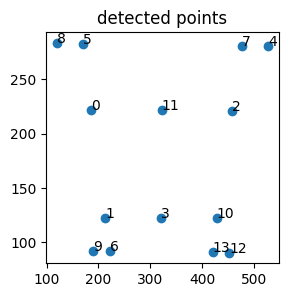

In [473]:
fig, ax = plt.subplots(figsize=(3,3))
ax.set_title("detected points")
ax.scatter(new[:,0], new[:,1])

for i, txt in enumerate(range(len(new))):
    ax.annotate(txt, (new[i,0], new[i,1]))

# 2,10,3,5

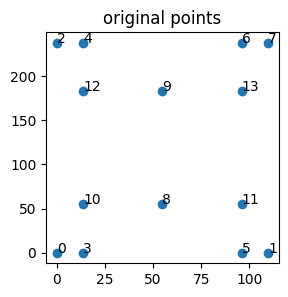

In [474]:
fig, ax = plt.subplots(figsize=(3,3))
ax.set_title("original points")
ax.scatter(original[:,0], original[:,1])

for i, txt in enumerate(range(len(original))):
    ax.annotate(txt, (original[i,0], original[i,1]))

# 12,9,10,8

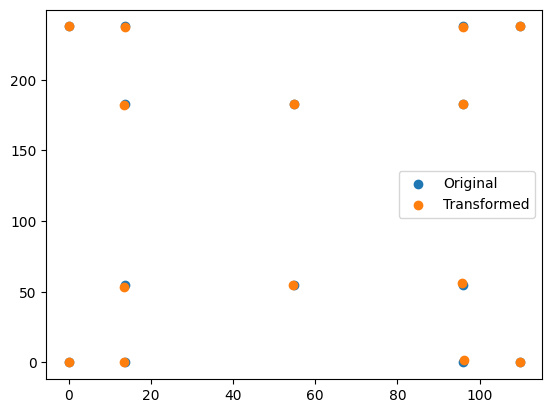

In [476]:

# M = cv2.getPerspectiveTransform(new[(8,4,9,12), :], original[(2,7,0,1), :]) # faster
# gives the same as
H, mask = cv2.findHomography(new[(8,4,9,12), :], original[(2,7,0,1), :], method=cv2.RANSAC, ransacReprojThreshold=5.0, maxIters=100000)


transformed_corners = cv2.perspectiveTransform(new.reshape(1, -1, 2), H).squeeze()
# transformed_corners = cv2.transform(new.reshape((-1,1,2)), homography)
# a,b = ims[0][:,:,0].shape
# output_image = cv2.warpPerspective(ims[0][:,:,0], homography, (23,50))
# plt.imshow(output_image)    
# plt.show()
plt.scatter(original[:, 0], original[:, 1], label='Original')
# plt.scatter(new[:, 0], new[:, 1], label='Preds')
plt.scatter(transformed_corners[:, 0], transformed_corners[:, 1], label='Transformed')
plt.legend()
plt.show()

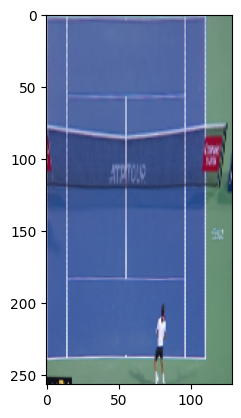

In [477]:
a = cv2.warpPerspective(ims[0], H, (int(cw)+20,int(ch)+20), cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))
plt.imshow(a)

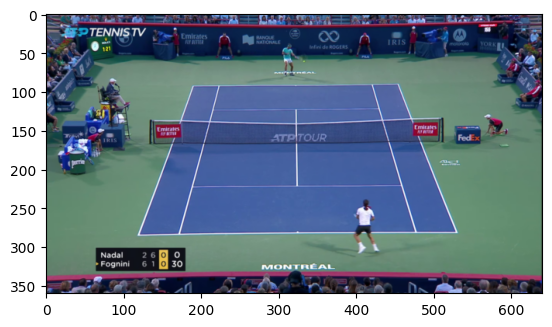

In [478]:
plt.imshow(ims[0])

### Normalize points

In [509]:
def normalize_points(points):
    return points - np.mean(points, axis=0)

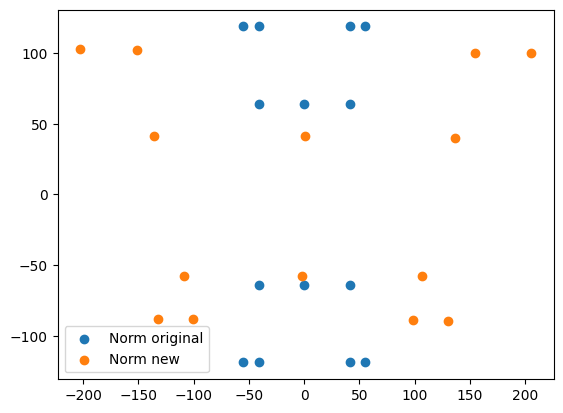

In [511]:
norm_org = normalize_points(original)
norm_new = normalize_points(new)

# plt.scatter(original[:, 0], original[:, 1], label='Original')
# plt.scatter(new[:, 0], new[:, 1], label='Preds')
plt.scatter(norm_org[:, 0], norm_org[:, 1], label='Norm original')
plt.scatter(norm_new[:, 0], norm_new[:, 1], label='Norm new')
plt.legend()
plt.show()

### Hungarian algortithm

In [494]:
# distances_matrix = np.array([ np.linalg.norm(original - p, axis=1) for p in new[(8,4,9,12),]])
distances_matrix = np.array([ np.linalg.norm(norm_org - p, axis=1) for p in norm_new[(8,4,9,12),]])

In [495]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html
new_ind, org_ind, = linear_sum_assignment(distances_matrix)

print(new_ind)
print(org_ind)
print(distances_matrix[new_ind, org_ind].sum())

[0 1 2 3]
[2 7 0 1]
464.91232


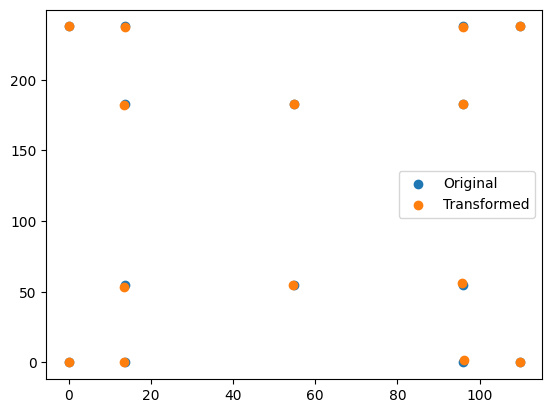

In [497]:

# H = cv2.getPerspectiveTransform(new[(8,4,9,12), :], original[(2,7,0,1), :]) # faster
# gives the same as
# H, mask = cv2.findHomography(new[new_ind, :], original[org_ind, :], method=cv2.RANSAC, ransacReprojThreshold=5.0, maxIters=1000000)
# H, mask = cv2.findHomography(new[(8,4,9,12), :], original[(2,7,0,1), :], method=cv2.RANSAC, ransacReprojThreshold=5.0, maxIters=100000)

transformed_corners = cv2.perspectiveTransform(new.reshape(1, -1, 2), H).squeeze()

plt.scatter(original[:, 0], original[:, 1], label='Original')
plt.scatter(transformed_corners[:, 0], transformed_corners[:, 1], label='Transformed')
plt.legend()
plt.show()

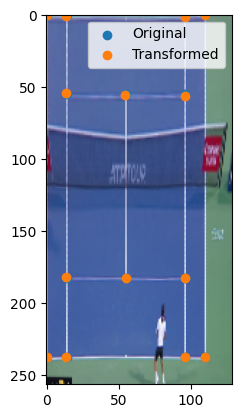

In [485]:
a = cv2.warpPerspective(ims[0], H, (int(cw)+20,int(ch)+20), cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))
plt.imshow(a)
plt.scatter(original[:, 0], original[:, 1], label='Original')
plt.scatter(transformed_corners[:, 0], transformed_corners[:, 1], label='Transformed')
plt.legend()
plt.show()

# Cleaning up / bringing it together

In [8]:
predictions = predict(model, dataloader)
predictions.shape

torch.Size([20, 256, 360, 640])

In [18]:
true_ims = [sample['image'].squeeze().permute(1,2,0).cpu().numpy() / 255 for sample in dataloader]
predicted_ims = torch.nn.Threshold(130, 0)(predictions.argmax(dim=1)).to(torch.uint8).cpu().numpy()
predicted_ims.shape

(20, 360, 640)

### Detect circles

In [87]:
def normalize_points(points):
    return points - np.mean(points, axis=0)

# def normalize_points(points: torch.Tensor) -> torch.Tensor:
#     return points - torch.mean(points, dim=0)

In [61]:
import cv2

predicted_points = []

for binary_image in predicted_ims:
    # Apply GaussianBlur to reduce noise and improve circle detection
    blurred_image = cv2.GaussianBlur(binary_image, (9, 9), 2)

    # Use Hough Circle Transform
    circles = cv2.HoughCircles(
        blurred_image,
        cv2.HOUGH_GRADIENT,
        dp=1,           # Inverse ratio of accumulator resolution to image resolution
        minDist=20,     # Minimum distance between the centers of the detected circles
        param1=10,      # Upper threshold for the edge detector
        param2=3,       # Threshold for center detection
        minRadius=1,    # Minimum radius of the detected circles
        maxRadius=20    # Maximum radius of the detected circles
    )
    if circles is not None:
        predicted_points.append(circles.squeeze()[:, :2])

In [68]:
for im, pred_points in zip(true_ims, predicted_points):
    norm_court_points = normalize_points(court_points)
    norm_pred_points = normalize_points(pred_points)

    distances_matrix = np.array([ np.linalg.norm(norm_court_points - p, axis=1) for p in norm_pred_points])    
    y_pred_idxs, y_idxs, = linear_sum_assignment(distances_matrix)

    H, mask = cv2.findHomography(pred_points[y_pred_idxs, :], court_points[y_idxs, :], method=cv2.RANSAC, ransacReprojThreshold=5.0, maxIters=1000000)

    transformed_corners = cv2.perspectiveTransform(pred_points.reshape(1, -1, 2), H).squeeze()
    transformed_im = cv2.warpPerspective(im, H, court_points.max(axis=0).astype(int) + 20, cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))

    plt.imshow(transformed_im)
    plt.scatter(court_points[:, 0], court_points[:, 1], label='Original')
    plt.scatter(transformed_corners[:, 0], transformed_corners[:, 1], label='Transformed')
    plt.legend()
    plt.show()


In [ ]:
x = predictions.argmax(dim = 1)
x = x.to(torch.uint8)
x = nn.Threshold(130, 0)(x)
x = transforms.GaussianBlur(kernel_size = (9,9), sigma = 2)(x)

# rest can not be parallelized i think
for im, image in zip(ims, x.cpu().numpy()):
    pred_points = cv2.HoughCircles(
        image,
        cv2.HOUGH_GRADIENT,
        dp=1,           # Inverse ratio of accumulator resolution to image resolution
        minDist=20,     # Minimum distance between the centers of the detected circles
        param1=10,      # Upper threshold for the edge detector
        param2=3,       # Threshold for center detection
        minRadius=1,    # Minimum radius of the detected circles
        maxRadius=20    # Maximum radius of the detected circles
    )
    pred_points = pred_points.squeeze()[:, :2]
    
    norm_court_points = normalize_points(court_points)
    norm_pred_points = normalize_points(pred_points)

    distances_matrix = np.array([ np.linalg.norm(norm_court_points - p, axis=1) for p in norm_pred_points])    
    y_pred_idxs, y_idxs, = linear_sum_assignment(distances_matrix)

    H, mask = cv2.findHomography(pred_points[y_pred_idxs, :], court_points[y_idxs, :], method=cv2.RANSAC, ransacReprojThreshold=5.0, maxIters=1000000)

    transformed_corners = cv2.perspectiveTransform(pred_points.reshape(1, -1, 2), H).squeeze()
    transformed_im = cv2.warpPerspective(im, H, court_points.max(axis=0).astype(int) + 20, cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))

    plt.imshow(transformed_im)
    plt.scatter(court_points[:, 0], court_points[:, 1], label='Original')
    plt.scatter(transformed_corners[:, 0], transformed_corners[:, 1], label='Transformed')
    plt.legend()
    plt.show()

# torch module

In [123]:
import torch.nn as nn


class PredictedPoints(torch.nn.Module):
    """ """
    def __init__(self) -> None:
        """ """
        super(PredictedPoints, self).__init__()
        
    def forward(self, x: torch.Tensor) -> list[np.ndarray]:
        """ """
        x = x.argmax(dim = 1)
        x = x.to(torch.uint8)
        x = nn.Threshold(130, 0)(x)
        x = transforms.GaussianBlur(kernel_size = (9,9), sigma = 2)(x)
        
        # rest can not be parallelized i think
        predicted_points = []
        for heatmap in x.cpu().numpy():
            pred_points = cv2.HoughCircles(
                heatmap,
                cv2.HOUGH_GRADIENT,
                dp=1,           # Inverse ratio of accumulator resolution to image resolution
                minDist=20,     # Minimum distance between the centers of the detected circles
                param1=10,      # Upper threshold for the edge detector
                param2=3,       # Threshold for center detection
                minRadius=1,    # Minimum radius of the detected circles
                maxRadius=20    # Maximum radius of the detected circles
            )
            predicted_points.append(pred_points.squeeze()[:, :2])
        
        return predicted_points
        

In [107]:
predicted_points = PredictedPoints()(predictions)

In [218]:
class FindHomography(torch.nn.Module):
    """ """
    def __init__(self) -> None:
        """ """
        super(FindHomography, self).__init__()
        
    def forward(self, y: np.ndarray, y_pred: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        """ """
        norm_y = normalize_points(y)
        norm_y_pred = normalize_points(y_pred)

        distances_matrix = np.array([ np.linalg.norm(norm_y_pred - p, axis=1) for p in norm_y])
        y_idxs, y_pred_idxs, = linear_sum_assignment(distances_matrix)

        H, _ = cv2.findHomography(y_pred[y_pred_idxs, :], y[y_idxs, :], method=cv2.RANSAC, ransacReprojThreshold=5.0, maxIters=10000)
        return H, y_pred_idxs

In [236]:
i = 0

H, correspondance = FindHomography()(court_points, predicted_points[i])

In [237]:
correspondance

array([ 9,  2, 13,  6, 12,  5,  4, 11,  3,  0,  8,  1, 10,  7])

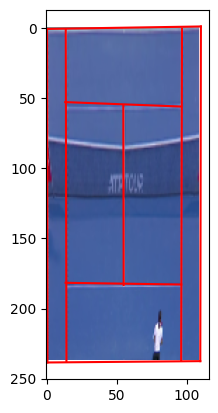

In [242]:

transformed_corners = cv2.perspectiveTransform(predicted_points[i].reshape(1, -1, 2), H).squeeze()
transformed_im = cv2.warpPerspective(ims[i], H, court_points.max(axis=0).astype(int), cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))

# transformed_corners = transformed_corners[correspondance]

plt.imshow(transformed_im)
# plt.scatter(court_points[:, 0], court_points[:, 1], label='Original')
# plt.scatter(transformed_corners[:, 0], transformed_corners[:, 1], label='Transformed')

for (a, b) in court_lines.values():
    ta = transformed_corners[correspondance[a]]
    tb = transformed_corners[correspondance[b]]
    # ta = court_point_positions[a]
    # tb = court_point_positions[b]
    # plt.scatter(ta[0], ta[1])
    # plt.scatter(tb[0], tb[1])
    plt.plot([ta[0], tb[0]], [ta[1], tb[1]], '-', c='r')
    # plt.plot([ta[0], tb[0]], [ta[0], tb[0]], '-', 'r')

# plt.scatter(transformed_corners[:,0], transformed_corners[:,1])

# for j, txt in enumerate(range(len(transformed_corners))):
#     plt.annotate(txt, (transformed_corners[j,0], transformed_corners[j,1]))

# 2,10,3,5
plt.show()

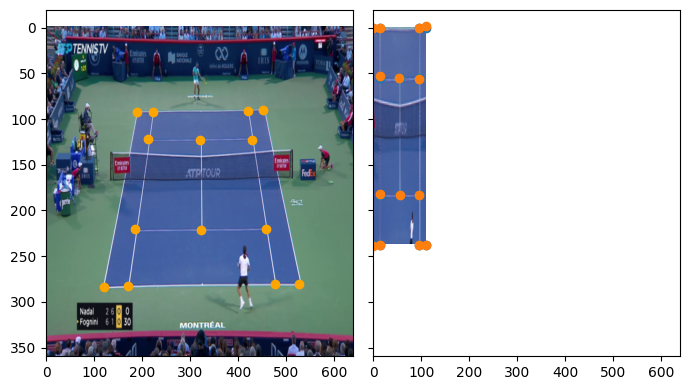

In [151]:
import matplotlib.pyplot as plt

fix, axs = plt.subplots(ncols=2, figsize=(7, 4), sharex=True, sharey=True)

axs[0].imshow(ims[i], aspect='auto')
axs[0].scatter(predicted_points[i][:, 0], predicted_points[i][:, 1], label='Transformed', c='orange')

axs[1].imshow(transformed_im, aspect='auto')
axs[1].scatter(court_points[:, 0], court_points[:, 1], label='Original')
axs[1].scatter(transformed_corners[:, 0], transformed_corners[:, 1], label='Transformed')

plt.tight_layout()
# axs[0].axis('off')
# axs[1].axis('off')
plt.show()
